# Code for generating main figure subpanels

- If run in order, this notebook allows for the generation of each figure subpanel.
- Author: Samuel I. Gould
- Email: samgould@mit.edu
- Originally run on Python 3.9.12

# Figure I

In [56]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pandas as pd
import os
import statannot
plt.rc('font', family='Helvetica')

import warnings
warnings.filterwarnings('ignore')

In [57]:
library = pd.read_csv('KEAP1_NRF2_library.csv')
library.loc[library['peg_type']=='nrf2_targeting', 'classification'] = 'nrf2_targeting'

#renaming the germline variants to VUS or driver
germline_drivers = ['p.R260L', 'p.R415H']
germline_vus = ['p.A184G', 'p.R536C', 'p.S508R', 'p.G480R', 'p.H210P', 'p.M550K', 'p.V465L']

library.loc[library['HGVSp'].isin(germline_drivers), 'classification'] = 'driver'
library.loc[library['HGVSp'].isin(germline_vus), 'classification'] = 'VUS'

#t = library[library['classification'].isin(['driver', 'VUS', 'germline', 'neutral'])]
t = library[library['classification'].isin(['driver', 'VUS', 'germline', 'neutral','nrf2_targeting'])]

hgs = t.drop_duplicates(subset='HGVSp')

u,c = np.unique(hgs['classification'], return_counts=True)

u2, c2 = np.unique(library['classification'], return_counts=True)

d_hg = pd.DataFrame(dict(zip(['Variant Type', 'Count'], [u,c])))

d_peg = pd.DataFrame(dict(zip(['Variant Type', 'Count'], [u2,c2])))

c_dict2 = {'VUS':'VUS', 'driver':'Oncogenic', 'germline':'Germline','nrf2_targeting':'NRF2', 'neutral':'Silent', 'safe-targeting control':'ST Control', 'non-targeting control':'NT Control'}

d_peg['Variant Type'] = [c_dict2[i] for i in d_peg['Variant Type']]
d_hg['Variant Type'] = [c_dict2[i] for i in d_hg['Variant Type']]

# Loading in Crispresso data

In [58]:
#first compiling crispresso into useable format
def crispresso_compiler(samp, sample_id):
    """ 
    Takes in list of sample names (see cell above)
    Returns compiled dictionary of dataframes containing editing information for each sensor
    
    Includes:
    1. corr_perc = pure correct editing
    2. target_base_edit_perc = target base editing perc (including edits with bystander editing)
    3. wt_perc
    4. byproduct information (indels, substitutions, ambiguous)
    """

    df_edits = []
    for k in samp: 
        concated = pd.read_csv(f'crispresso/{k}_crispresso_aggregated.csv')
        concated = concated.fillna(0)

        #somehow wasn't able to find the initial set of code that I used for this...

        #go through all of the samples and do it step by step
        sample_ids = []
        #sample_num = []
        rii = []
        raaa = []
        r_lowqual = []
        ra_hdr = []
        ra_wt = []
        r_unaligned = []
        no_edit = []
        correct = []
        target_base_editing = []
        byproduct_all = []
        byproduct_indel = []
        byproduct_sub = []
        byproduct_ambig = []
        for i in np.unique(concated['peg_id']):
            sample_ids.append(i)

            subset = concated[concated['peg_id']==i]

            wt = subset[subset['Amplicon']=='Reference']
            edit = subset[subset['Amplicon']=='HDR']

            #sample_num.append(wt['sample_num'].values[0])
            rii1 = wt['Reads_in_input'].values[0]
            r1 = wt['Reads_aligned_all_amplicons'].values[0]
            rii.append(rii1)
            raaa.append(r1)
            r_lowqual.append(rii1-r1)

            r2 = edit['Reads_aligned'].values[0]
            r3 = wt['Reads_aligned'].values[0]
            ra_hdr.append(r2)
            ra_wt.append(r3)
            r_unaligned.append(r1 - (r2+r3))

            no_edit.append(wt['Unmodified'].values[0])
            correct.append(edit['Unmodified'].values[0])
            target_base_editing.append(edit['Modified'].values[0] + edit['Unmodified'].values[0])

            byprod_all = wt['Modified'].values[0] + edit['Modified'].values[0] + (r1 - (r2+r3)) #add unaligned reads
            sub_all = wt['Only Substitutions'].values[0] + edit['Only Substitutions'].values[0]
            indel_all = wt['Only Deletions'].values[0] + wt['Only Insertions'].values[0] + wt['Insertions and Deletions'].values[0] + edit['Only Deletions'].values[0] + edit['Only Insertions'].values[0] + edit['Insertions and Deletions'].values[0]
            ambig_all = byprod_all - sub_all - indel_all

            byproduct_all.append(byprod_all)
            byproduct_indel.append(indel_all)
            byproduct_sub.append(sub_all)
            byproduct_ambig.append(ambig_all)


        cols = ["pegRNA_id", "Reads_in_input","Reads_lowqual", "Reads_aligned_all_amplicons","Reads_aligned_WT", "Reads_aligned_HDR", "Reads_unaligned", "WT","correct_edit", "target_base_edit", "byproduct_all","byproduct_INDEL","byproduct_sub","byproduct_ambiguous"]
        col_vals = [ sample_ids, rii, r_lowqual, raaa, ra_wt, ra_hdr, r_unaligned, no_edit, correct, target_base_editing, byproduct_all, byproduct_indel, byproduct_sub, byproduct_ambig]

        out = pd.DataFrame(dict(zip(cols, col_vals)))
        out['corr_perc'] = 100*(out['correct_edit']/out['Reads_aligned_all_amplicons'])
        out['target_base_edit_perc'] = 100*(out['target_base_edit']/out['Reads_aligned_all_amplicons'])
        out['WT_perc'] = 100*(out['WT']/out['Reads_aligned_all_amplicons'])
        out['byproduct_all_perc'] =  100*(out['byproduct_all']/out['Reads_aligned_all_amplicons'])
        out['byproduct_INDEL_perc'] =  100*(out['byproduct_INDEL']/out['Reads_aligned_all_amplicons'])
        out['byproduct_sub_perc'] =  100*(out['byproduct_sub']/out['Reads_aligned_all_amplicons'])
        out['byproduct_ambiguous_perc'] =100*(out['byproduct_ambiguous']/out['Reads_aligned_all_amplicons'])
        out = out.fillna(0)

        df_edits.append(out)

    edit_dict = dict(zip(sample_id, df_edits))

    return edit_dict


In [59]:
l2 = sorted(os.listdir('crispresso'))
samp = [i.split('_')[0] for i in l2]

d = {'D24-8256' : 'REP1_Q1',
'D24-8257' : 'REP1_Q2',
'D24-8258' : 'REP1_Q3',
'D24-8259' : 'REP1_Q4', 
'D24-8260' : 'REP2_Q1',
'D24-8261' : 'REP2_Q2',
'D24-8262' : 'REP2_Q3',
'D24-8263' : 'REP2_Q4',
'D24-8264' : 'REP3_Q1',
'D24-8265' : 'REP3_Q2',
'D24-8266' : 'REP3_Q3',
'D24-8267' : 'REP3_Q4',
'D24-8268' : 'REP1_PreSort',
'D24-8269' : 'REP2_PreSort',
'D24-8270' : 'REP3_PreSort',
'D24-8271' : 'Plasmid_Library'}

sample_id = list(d.values())

#edit_dict contains dataframe of editing information for each pegRNA for each sample
edit_dict = crispresso_compiler(samp, sample_id)

In [60]:
#merging the replicates from the pre-sort populations
#to generate a maximum likelihood estimate for the editing efficiency of each pegRNA pre-sort

#making a presort best estimate
cols = ["Reads_in_input","Reads_lowqual", "Reads_aligned_all_amplicons","Reads_aligned_WT", "Reads_aligned_HDR", "Reads_unaligned", "WT","correct_edit", "target_base_edit", "byproduct_all","byproduct_INDEL","byproduct_sub","byproduct_ambiguous"]

list(edit_dict['REP1_PreSort']['pegRNA_id']) == list(edit_dict['REP2_PreSort']['pegRNA_id']) == list(edit_dict['REP3_PreSort']['pegRNA_id'])

out = edit_dict['REP1_PreSort'][cols] + edit_dict['REP2_PreSort'][cols]+edit_dict['REP3_PreSort'][cols]
out['pegRNA_id'] = edit_dict['REP1_PreSort']['pegRNA_id']

out['corr_perc'] = 100*(out['correct_edit']/out['Reads_aligned_all_amplicons'])
out['target_base_edit_perc'] = 100*(out['target_base_edit']/out['Reads_aligned_all_amplicons'])
out['WT_perc'] = 100*(out['WT']/out['Reads_aligned_all_amplicons'])
out['byproduct_all_perc'] =  100*(out['byproduct_all']/out['Reads_aligned_all_amplicons'])
out['byproduct_INDEL_perc'] =  100*(out['byproduct_INDEL']/out['Reads_aligned_all_amplicons'])
out['byproduct_sub_perc'] =  100*(out['byproduct_sub']/out['Reads_aligned_all_amplicons'])
out['byproduct_ambiguous_perc'] =100*(out['byproduct_ambiguous']/out['Reads_aligned_all_amplicons'])
out = out.fillna(0)

presort_mle_edit = out

In [61]:
m1 = pd.merge(library,presort_mle_edit,  on='pegRNA_id')
counts_threshold = 50 #minimum number of sensor reads for inclusion
m1 = m1[m1['Reads_aligned_all_amplicons']>=counts_threshold]
targ = m1[~m1['peg_type'].isin(['safe_targeting', 'non_targeting'])]

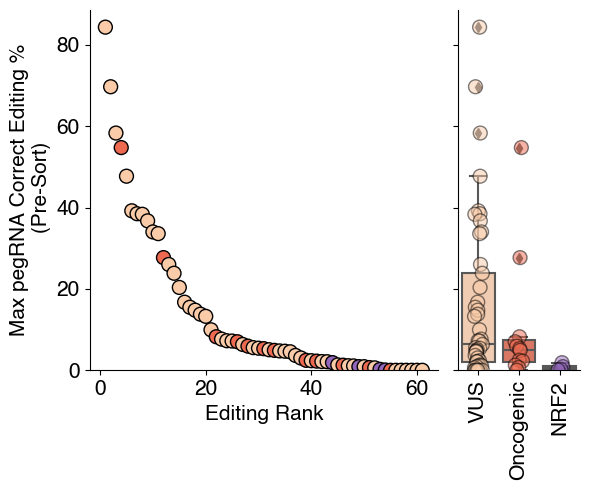

In [62]:
hgs = np.unique(targ['HGVSp'])
i_maxs = []
for i in hgs:
    sub = targ[targ['HGVSp']==i]
    i_max = max(sub['corr_perc'])
    i_maxs.append(i_max)

maxes = pd.DataFrame(dict(zip(['HGVSp', 'Max_corr_perc'], [hgs, i_maxs]))).sort_values(by='Max_corr_perc',ascending=False)

m4 = pd.merge(maxes, library, on='HGVSp').fillna(0).drop_duplicates('HGVSp')
m4 = m4[m4['classification']!='neutral']
#c_dict = {1:'tab:red', 0:'tab:blue'}
#c_dict2 = {1:'Driver', 0:'Vus'}


#WT = #7284A1
#VUS = #F9CBA8
#Oncogenic/Driver = #ED6A50

c_dict = {'VUS':'#F9CBA8', 'driver':'#ED6A50', 'nrf2_targeting':'tab:purple'}
c_dict2 = {'VUS':'VUS', 'driver':'Oncogenic', 'nrf2_targeting':'NRF2'}

m4['color'] = [c_dict[i] for i in m4['classification']]
m4['label'] = [c_dict2[i] for i in m4['classification']]
m4['rank'] = list(range(1, len(m4)+1))

fig, ax = plt.subplots(1,2, figsize=(6,5), sharey=True, width_ratios=[2,.7])

hue_order = ['VUS', 'Oncogenic', 'NRF2']

ax[0].scatter(m4['rank'], m4['Max_corr_perc'], color = m4['color'], label=m4['label'], s=100, edgecolor='black', linewidth=1)
sns.boxplot(data = m4, x='label', y='Max_corr_perc', ax=ax[1], order =hue_order, palette=c_dict.values())
sns.stripplot(data = m4, x='label', y='Max_corr_perc', ax=ax[1], hue='label', order=hue_order, hue_order =hue_order, palette=c_dict.values(), s=10, edgecolor='black', alpha=.5, legend=False,linewidth=1, dodge=False)
#ax[0].legend(fontsize=15)
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[0].spines[['top', 'right']].set_visible(False)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].spines[['top', 'right']].set_visible(False)
ax[1].tick_params(axis='both', which='major', labelsize=15)

ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[0].set_ylim(0,)
#ax[0].set_title(f'Sensor Count ≥{counts_threshold}', fontsize=17)
ax[0].set_ylabel('Max pegRNA Correct Editing %\n (Pre-Sort)', fontsize=15)
ax[0].set_xlabel('Editing Rank', fontsize=15)
fig.tight_layout()
#fig.savefig('edit_ratev4.pdf')


# Figure J

- Merging crispresso data with library and MAGeCK results
- Filtering out variants with less than 30 control mean counts 
- Filtering out variants that enrich in all bins (LFC > 0.1)

In [63]:
library = pd.read_csv('KEAP1_NRF2_library.csv')
library.loc[library['peg_type']=='nrf2_targeting', 'classification'] = 'nrf2_targeting'

germline_drivers = ['p.R260L', 'p.R415H']
germline_vus = ['p.A184G', 'p.R536C', 'p.S508R', 'p.G480R', 'p.H210P', 'p.M550K', 'p.V465L']

library.loc[library['HGVSp'].isin(germline_drivers), 'classification'] = 'driver'
library.loc[library['HGVSp'].isin(germline_vus), 'classification'] = 'VUS'

hgvsp = []
for i, val in library.iterrows():
    h = val['HGVSp']
    if type(h)==str:
        if h[:2]=='p.':
            hgvsp.append(h[2:])
        else:
            hgvsp.append(h)
    else:
        hgvsp.append(None)

library['HGVSp']=hgvsp

In [64]:
#loading in MAGeCK data and merging with library
m1 = pd.merge(library,presort_mle_edit,  on='pegRNA_id')

q4_presort_mageck = pd.read_csv('mageck/Q4_presort_PAIRED_controls.sgrna_summary.txt', sep='\t').sort_values(by='LFC', ascending=False)
q3_presort_mageck = pd.read_csv('mageck/Q3_presort_PAIRED_controls.sgrna_summary.txt', sep='\t').sort_values(by='LFC', ascending=False)
q2_presort_mageck = pd.read_csv('mageck/Q2_presort_PAIRED_controls.sgrna_summary.txt', sep='\t').sort_values(by='LFC', ascending=False)
q1_presort_mageck = pd.read_csv('mageck/Q1_presort_PAIRED_controls.sgrna_summary.txt', sep='\t').sort_values(by='LFC', ascending=False)
q1q2_presort_mageck = pd.read_csv('mageck/Q1Q2_presort_PAIRED_controls.sgrna_summary.txt', sep='\t').sort_values(by='LFC', ascending=False)

#specifically for --paired option, need to do this (each replicate is dealt with separately)
q4_presort_mageck['pegRNA_id'] = [i[:-3] for i in q4_presort_mageck['sgrna']]
q3_presort_mageck['pegRNA_id'] = [i[:-3] for i in q3_presort_mageck['sgrna']]
q2_presort_mageck['pegRNA_id'] = [i[:-3] for i in q2_presort_mageck['sgrna']]
q1_presort_mageck['pegRNA_id'] = [i[:-3] for i in q1_presort_mageck['sgrna']]
q1q2_presort_mageck['pegRNA_id'] = [i[:-3] for i in q1q2_presort_mageck['sgrna']]

q4 = pd.merge(m1,q4_presort_mageck,  on='pegRNA_id')
q3 = pd.merge(m1,q3_presort_mageck,  on='pegRNA_id')
q2 = pd.merge(m1,q2_presort_mageck,  on='pegRNA_id')
q1 = pd.merge(m1,q1_presort_mageck,  on='pegRNA_id')
q1q2 = pd.merge(m1,q1q2_presort_mageck,  on='pegRNA_id')

q4['bin'] = 'Q4 - High'
q3['bin'] = 'Q3 - Mid-high'
q2['bin'] = 'Q2 - Mid-low'
q1['bin'] = 'Q1 - Low'
q1q2['bin'] = 'Q1 + Q2 – Low'

m2 = pd.concat((q4, q3, q2, q1, q1q2))

m2['replicate'] = [i[-2:] for i in m2['sgrna']]

In [65]:
#want to filter out things that enrich in ALL of the bins
#these are possibly PCR induced errors or noisy artifacts

uniq_sgrnas = np.unique(m2['sgrna'])

cutoff=0.1

sg_list = []
for i in uniq_sgrnas:

    subset1 = m2[m2['sgrna']==i]

    q1 = subset1.loc[subset1['bin']=='Q1 - Low', 'LFC'].values[0]
    q2 = subset1.loc[subset1['bin']=='Q2 - Mid-low', 'LFC'].values[0]
    q3 = subset1.loc[subset1['bin']=='Q3 - Mid-high', 'LFC'].values[0]
    q4 = subset1.loc[subset1['bin']=='Q4 - High', 'LFC'].values[0]

    if (q1>cutoff) & (q2>cutoff) & (q3>cutoff) & (q4>cutoff):
        sg_list.append(i)

In [66]:
min_control_counts = 30
min_corr_perc = 40
min_corr_perc_silent = 20
counts_threshold = 50

#filter pegRNAs below control count threshold (30)
m3 = m2[m2['control_mean']>=min_control_counts]
#filter pegRNAs that enrich in all bins
m3 = m3[~m3['sgrna'].isin(sg_list)]
#designate control pegRNAs
controls = m3[m3['peg_type'].isin(['safe_targeting', 'non_targeting'])]

#filter pegRNAs without sufficient sensor reads
targeting = m3[~m3['peg_type'].isin(['safe_targeting', 'non_targeting'])]
targeting = targeting[targeting['Reads_aligned_all_amplicons']>=counts_threshold]

#filter pegRNAs below editing editing threshold (min_corr_perc)
silent = targeting[targeting['peg_type'].isin(['keap1_silent'])]
targeting2 = targeting[~targeting['peg_type'].isin(['keap1_silent'])]


targeting2 = targeting2[targeting2['corr_perc']>=min_corr_perc]
silent = silent[silent['corr_perc']>=min_corr_perc_silent]


comb1 = pd.concat((controls, targeting2, silent))

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Silent v.s. ST Control: t-test independent samples with Bonferroni correction, P_val=2.787e-01 stat=1.829e+00
VUS v.s. Oncogenic: t-test independent samples with Bonferroni correction, P_val=3.867e-01 stat=1.732e+00
Oncogenic v.s. ST Control: t-test independent samples with Bonferroni correction, P_val=2.773e-03 stat=3.476e+00
VUS v.s. ST Control: t-test independent samples with Bonferroni correction, P_val=8.100e-11 stat=7.314e+00


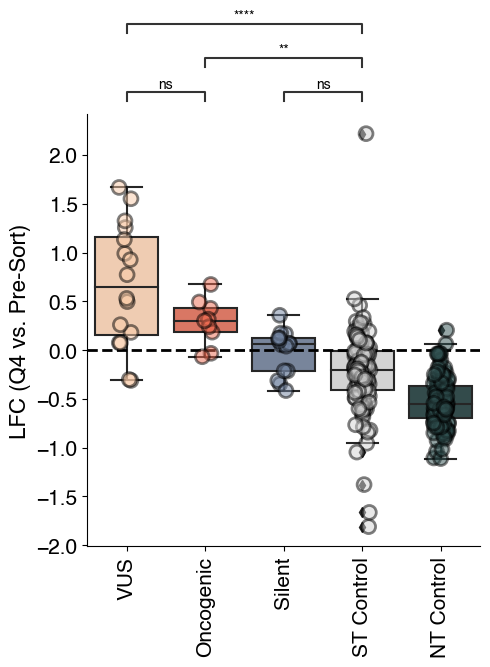

In [67]:
import statannot


fig, ax = plt.subplots(1,1, figsize=(5,7), sharey=True) #, width_ratios=[.7,1.2])

comb2 = comb1[comb1['bin']=='Q4 - High']

c_dict2 = {'VUS':'VUS', 'driver':'Oncogenic', 'germline':'Germline', 'neutral':'Silent', 'nrf2_targeting':'NRF2', 'non-targeting control': 'NT Control', 'safe-targeting control':'ST Control'}

palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']

order2 = ['VUS', 'Oncogenic', 'Silent', 'ST Control', 'NT Control']
comb2['label'] = [c_dict2[i] for i in comb2['classification']]

sns.boxplot(data = comb2, x='label', y='LFC', ax=ax, order=order2, palette=palette,showfliers=True);
sns.stripplot(data = comb2, x='label', y='LFC', ax=ax, hue='label', edgecolor='black',linewidth=2, s=10,alpha=.5, legend=False,hue_order=order2, order=order2, palette=palette);

#second part of plot
#targeting2 = comb2[comb2['label'].isin(['VUS', 'Oncogenic', 'Germline', 'Silent'])]

#targeting2 = targeting2.sort_values(by='LFC', ascending=False)

#sns.boxplot(data = targeting2, x='HGVSp', y='LFC', ax=ax[1], hue='label', dodge=False, hue_order= ['VUS', 'Oncogenic', 'Silent'], palette = palette,showfliers=True); #order=order,
#sns.stripplot(data = targeting2, x='HGVSp', y='LFC', ax=ax[1], hue='label',  hue_order= ['VUS', 'Oncogenic', 'Silent'], palette = palette, edgecolor='black',linewidth=2, s=10,alpha=.5, legend=False, dodge=False);#order=order,


statannot.add_stat_annotation(
    ax,
    data=comb2,
    x='label',
    y='LFC',
    #hue=hue,
    order=order2,
    box_pairs=[
        (("VUS"), ("ST Control")),
        (("Oncogenic"), ("ST Control")),
        (("ST Control"), ("Silent")),
        (("VUS"), ("Oncogenic")),


    ],
    test="t-test_ind",
    text_format="star",
    loc="outside",
)

#ax[0].set_ylim(-2,2)
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
#ax[1].legend(fontsize=15)
#ax[1].legend().set_visible(False)

#ax[1].plot([-0.5,15.5], [0,0], linewidth=2, linestyle='dashed', color='black')
ax.set_xlabel('')
ax.set_ylabel('LFC (Q4 vs. Pre-Sort)', fontsize=16)
#ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)



#ax[1].spines[['top', 'right']].set_visible(False)
#ax[1].tick_params(axis='both', which='major', labelsize=15)

ax.plot([-0.5,4.5], [0,0], linewidth=2, linestyle='dashed', color='black')
#ax[1].set_xlabel('')
#ax[1].set_ylabel('')
fig.tight_layout()
#fig.savefig('panel_J.pdf')

# Figure K

In [68]:
min_control_counts = 30
min_corr_perc = 40
min_corr_perc_silent = 20
counts_threshold = 50

#filter pegRNAs below control count threshold (30)
m3 = m2[m2['control_mean']>=min_control_counts]
#filter pegRNAs that enrich in all bins
m3 = m3[~m3['sgrna'].isin(sg_list)]
#designate control pegRNAs
controls = m3[m3['peg_type'].isin(['safe_targeting', 'non_targeting'])]

controls.loc[controls['peg_type']=='safe_targeting', 'HGVSp'] = 'ST Control'
controls.loc[controls['peg_type']=='non_targeting', 'HGVSp'] = 'NT Control'


#filter pegRNAs without sufficient sensor reads
targeting = m3[~m3['peg_type'].isin(['safe_targeting', 'non_targeting'])]
targeting = targeting[targeting['Reads_aligned_all_amplicons']>=counts_threshold]

#filter pegRNAs below editing editing threshold (min_corr_perc)
silent = targeting[targeting['peg_type'].isin(['keap1_silent'])]
targeting2 = targeting[~targeting['peg_type'].isin(['keap1_silent'])]


targeting2 = targeting2[targeting2['corr_perc']>=min_corr_perc]
silent = silent[silent['corr_perc']>=min_corr_perc_silent]


comb1 = pd.concat((controls, targeting2, silent))

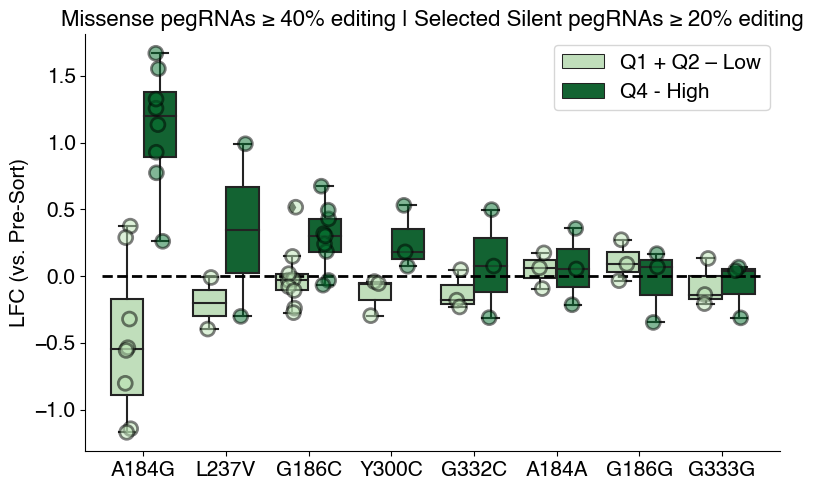

In [69]:
fig, ax = plt.subplots(figsize=(8,5))
pal = sns.color_palette('Greens')
j = pal.as_hex()
palette = [j[1], j[5], 'tab:grey', 'tab:grey']

order = ['A184G',
 'L237V',
 'G186C',
 'Y300C',
 'G332C',
 'A184A',
 'G186G',
 'G333G',
 ]

comb1 = comb1[comb1['HGVSp'].isin(order)]

hue_order = ['Q1 + Q2 – Low', 'Q4 - High']


sns.boxplot(data = comb1, x='HGVSp', y='LFC', ax=ax,hue='bin', dodge=True, order=order, hue_order = hue_order, palette=palette);
sns.stripplot(data = comb1, x='HGVSp', y='LFC', ax=ax, hue='bin', edgecolor='black',linewidth=2, s=10,alpha=.5, legend=False, dodge=True, order=order, hue_order = hue_order, palette=palette);
#plt.ylim(-1.5, 1.5)

ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(fontsize=15)
ax.set_ylabel('LFC (vs. Pre-Sort)', fontsize=15)
ax.set_xlabel('')
ax.set_title(f'Missense pegRNAs ≥ {min_corr_perc}% editing | Selected Silent pegRNAs ≥ {min_corr_perc_silent}% editing', fontsize=16)
ax.plot([-0.5,7.5], [0,0], linewidth=2, linestyle='dashed', color='black')
#ax.set_ylim(-2,)

fig.tight_layout()
#fig.savefig('fig_5k_v2.pdf')

# Figure L

In [70]:
validation_flow = pd.read_csv('ARE-GFP_and_PEAR_flow_data/keap1_2024_7_23_validation_day10.csv')
validation_flow.loc[validation_flow['Sample']=='ST', 'Sample'] = 'ST Control'
validation_flow.loc[validation_flow['Sample']=='NT', 'Sample'] = 'NT Control'
validation_flow

,Unnamed: 0,Sample,RFP+BFP+ Count,RFP+BFP+ %,GFP+ Count,GFP+ %
0,Specimen_001_uncolored.fcs,Uncolored,0,0.0,0,0.00
1,Specimen_001_untransduced_1.fcs,Untransduced,0,0.0,0,0.00
2,Specimen_001_1a.fcs,A184G,7332,81.7,1172,16.00
3,Specimen_001_1b.fcs,A184G,7406,81.7,1188,16.00
4,Specimen_001_1c.fcs,A184G,7306,81.9,1110,15.20
5,Specimen_001_3a.fcs,G186C,7937,89.0,370,4.66
6,Specimen_001_3b.fcs,G186C,8007,88.6,524,6.54
7,Specimen_001_3c.fcs,G186C,8084,89.9,599,7.41
8,Specimen_001_6a.fcs,A184A,7727,82.2,230,2.98
9,Specimen_001_6b.fcs,A184A,7730,81.9,223,2.88


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

A184G v.s. A184A: t-test independent samples with Bonferroni correction, P_val=2.989e-06 stat=4.472e+01
G186C v.s. G186G: t-test independent samples with Bonferroni correction, P_val=1.791e-02 stat=4.753e+00


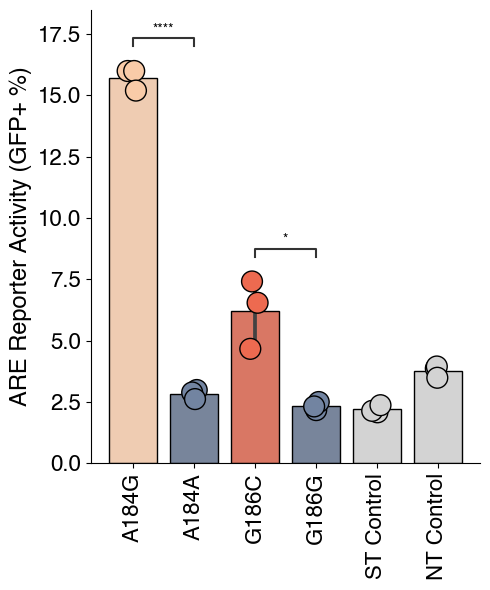

In [71]:
subset = validation_flow[validation_flow['Sample'].isin(['A184G', 'A184A', 'G186C', 'G186G', 'ST Control', 'NT Control',])]
fig, ax = plt.subplots(figsize=(5,6))

order = ['A184G', 'A184A', 'G186C', 'G186G', 'ST Control', 'NT Control',]
palette = ['#F9CBA8', '#7284A1','#ED6A50', '#7284A1', 'lightgrey', 'lightgrey']

sns.barplot(data = subset, x='Sample', y='GFP+ %', color='tab:blue', edgecolor='black', linewidth=1, ax=ax, order=order, palette=palette)
sns.stripplot(data = subset, x='Sample', y='GFP+ %', ax=ax, s=15, linewidth=1, dodge=False, edgecolor='black',order=order,palette=palette)
ax.set_xlabel('')
ax.set_ylabel('ARE Reporter Activity (GFP+ %)', fontsize=17)
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', labelsize=16)

ax.set_xticklabels(labels=order, rotation=90)

statannot.add_stat_annotation(
    ax,
    data=subset,
    x='Sample',
    y='GFP+ %',
    order=order,
    #hue=hue,
    box_pairs=[
        (("A184G"), ("A184A")),
        (("G186C"), ("G186G")),
       # (("G186C"), ("ST")),
        #(("G186C"), ("NT")),
        #(("A184G"), ("NT + tBHQ"))
    ],
    test="t-test_ind",
    text_format="star",
    loc="inside",
)

fig.tight_layout()
#fig.savefig('validation.pdf')